## Libraries

In [35]:
from collections import Counter,defaultdict
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
import json
from bs4 import BeautifulSoup
import sys
import os

#os.environ['KERAS_BACKEND']='theano'

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Merge, Dropout
from keras.models import Model
from keras.callbacks import Callback

from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB

import re

## Load-In Data/Pre-process

### Selection

In [44]:
testing = ["NB","SGD","LG","RF"]

### Combined

In [53]:
def preprocess(article):
    article = article.encode('utf-8')
    article = str(article.lower())
    return removeTagsInterpuntion(article)

def removeTagsInterpuntion(article): #remove URL's, HTML-tags and interpuntion
    article = re.sub("^https?:\/\/.*[\r\n]*", '', article)
    article = re.sub('\\\\x\w\w', '', article)
    article = re.sub('[^a-z\s]', '', article)
    return article

def loadData(path, texts, labels, highLevelLabels = False):
    with open(path) as data_file:    
        data = json.load(data_file)
    for article in data:
        text = preprocess(article["content"])
        if len(text.split()) > 9 and article["category"] != "NOCAT": #Remove small sentences
            texts.append(text)
            if highLevelLabels:
                label = article["category"].split("|")
                labels.append(label[0])
            else:
                labels.append(article["category"])
    return texts, labels

In [54]:
texts = []
labels = []
paths = [#r"C:\Users\PC-Axel\Documents\github\thesis\Data\PoliFLW Data\kamerstukken_topics_first.json",
        r"C:\Users\PC-Axel\Documents\github\thesis\Data\PoliFLW Data\kamerstukken_topics.json",
        r"C:\Users\PC-Axel\Documents\github\thesis\Data\PoliFLW Data\kamerstukken_topics_2016.json"]

for path in paths:
    texts, labels = loadData(path, texts, labels)
    

#Prepare splitting
VALIDATION_SPLIT = 0.2
indices = np.arange(len(labels))
np.random.shuffle(indices)
texts = np.array(texts)[indices]
labels = np.array(labels)[indices]
nb_validation_samples = int(VALIDATION_SPLIT * labels.shape[0])

### CNN

In [39]:
if "CNN" in testing or "CNNPlus" in testing:
    MAX_SEQUENCE_LENGTH = 1000
    MAX_NB_WORDS = 20000
    EMBEDDING_DIM = 160
    
    lb = preprocessing.LabelBinarizer()
    labelsCNN = lb.fit_transform(labels)

    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)

    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

    print('Shape of data tensor:', data.shape)
    print('Shape of label tensor:', labelsCNN.shape)

    x_train = data[:-nb_validation_samples]
    y_train = labelsCNN[:-nb_validation_samples]
    x_val = data[-nb_validation_samples:]
    y_val = labelsCNN[-nb_validation_samples:]
    
    
    print('Class distribution in training and validation set ')
    print(y_train.sum(axis=0))
    print(y_val.sum(axis=0))

### Baselines

In [55]:
if "NB" in testing or "SGD" in testing:
    xTrain = texts[:-nb_validation_samples]
    yTrain = labels[:-nb_validation_samples]
    xVal = texts[-nb_validation_samples:]
    yVal = labels[-nb_validation_samples:]
    
    transformer = TfidfVectorizer(smooth_idf=True, min_df=0.00000001, max_df=0.2, sublinear_tf=True)
    
    xTrain = transformer.fit_transform(xTrain)
    xVal = transformer.transform(xVal)

In [58]:
def evaluation(yVal,yPred):
    print("Accuracy is " + str(accuracy_score(yVal, yPred)))
#     print(f1_score(yVal, yPred, average='macro'),f1_score(yVal, yPred, average='micro'), 
#         f1_score(yVal, yPred, average='weighted'))
#     print(precision_score(yVal, yPred, average='macro'),precision_score(yVal, yPred, average='micro'), 
#         precision_score(yVal, yPred, average='weighted'))
#     print(recall_score(yVal, yPred, average='macro'),recall_score(yVal, yPred, average='micro'), 
#         recall_score(yVal, yPred, average='weighted'))
#    print(classification_report(yVal, yPred))

In [43]:
from sklearn.grid_search import GridSearchCV

if "NB" in testing:
    clf = MultinomialNB()
    clf = OneVsRestClassifier(clf)#.fit(xTrain, yTrain)
    #yPred = clf.predict(xVal)
    #evaluation(yVal,yPred)
    
    parameters = {
        "estimator__fit_prior": [True, False],
    }
    model_tunning = GridSearchCV(clf, param_grid=parameters).fit(xTrain, yTrain)
    print(model_tunning.best_score_)
    print(model_tunning.best_params_ )


0.6544644922507518
{'estimator__fit_prior': False}


In [59]:
if "SGD" in testing:
    clf = SGDClassifier(loss='log', penalty='l1', alpha=1e-6, random_state=42, max_iter=10, tol=None)
    clf = OneVsRestClassifier(clf).fit(xTrain, yTrain)
    yPred = clf.predict(xVal)
    evaluation(yVal,yPred)
    
    
#     parameters = {
#         "estimator__loss": ["hinge", "log", "modified_huber", "squared_hinge", "perceptron"],
#         "estimator__penalty": ["none", "l2", "l1", "elasticnet"],
#         "estimator__alpha": [0.0001,0.00001],
#     }
#     model_tunning = GridSearchCV(clf, param_grid=parameters).fit(xTrain, yTrain)
#     print(model_tunning.best_score_)
#     print(model_tunning.best_params_ )

Accuracy is 0.9408629877943957


In [61]:
clf = SGDClassifier(loss='modified_huber', penalty='l2', alpha=1e-5, max_iter=10, tol=None)
clf = OneVsRestClassifier(clf).fit(xTrain, yTrain)
yPred = clf.predict(xVal)
evaluation(yVal,yPred)

Accuracy is 0.9400034381983841


In [11]:
if "LG" in testing:
    clf = LogisticRegression()
    clf = OneVsRestClassifier(clf).fit(xTrain, yTrain)
    yPred = clf.predict(xVal)
    evaluation(yVal,yPred)
    
    parameters = {
        "estimator__fit_prior": [True, False],
    }
    model_tunning = GridSearchCV(clf, param_grid=parameters).fit(xTrain, yTrain)
    print(model_tunning.best_score_)
    print(model_tunning.best_params_ )

In [12]:
if "RF" in testing:
    clf = RandomForestClassifier()
    clf = OneVsRestClassifier(clf).fit(xTrain, yTrain)
    yPred = clf.predict(xVal)
    evaluation(yVal,yPred)
    
    parameters = {
        "estimator__fit_prior": [True, False],
    }
    model_tunning = GridSearchCV(clf, param_grid=parameters).fit(xTrain, yTrain)
    print(model_tunning.best_score_)
    print(model_tunning.best_params_ )

## Train Models and evaluate

### CNN

In [27]:
if "CNN" in testing or "CNN+" in testing:
    GLOVE_DIR = r"C:\Users\PC-Axel\Documents\Codeer projecten\Word2Vec Vectoren\Nederlandse word2vec\combined-160.txt"
    embeddings_index = {}
    f = open(GLOVE_DIR, encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 1442951 word vectors in Glove 6B 100d.


In [14]:
import keras
import numpy as np
import sklearn.metrics as sklm


class Metrics(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.confusion = []
        self.precision = []
        self.recall = []
        self.f1s = []
        self.kappa = []
        self.auc = []

    def on_epoch_end(self, epoch, logs={}):
        score = np.asarray(self.model.predict(self.validation_data[0]))
        predict = np.round(np.asarray(self.model.predict(self.validation_data[0])))
        predict = lb.inverse_transform(predict, threshold=None)
        targ = self.validation_data[1]
        targ = lb.inverse_transform(targ, threshold=None)
        
        print(print(classification_report(targ, predict)))
        self.confusion.append(sklm.confusion_matrix(targ, predict))
        self.precision.append(sklm.precision_score(targ, predict, average=None))
        self.recall.append(sklm.recall_score(targ, predict, average=None))
        self.f1s.append(sklm.f1_score(targ, predict, average=None))

        return
metrics = Metrics()

In [16]:
if "CNN" in testing:
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    embedding_layer = Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True)

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
    l_pool1 = MaxPooling1D(5)(l_cov1)
    l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
    l_pool2 = MaxPooling1D(5)(l_cov2)
    l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
    l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
    l_flat = Flatten()(l_pool3)
    l_dense = Dense(128, activation='relu')(l_flat)
    preds = Dense(labelsCNN.shape[1], activation='softmax')(l_dense)

    modelCNN = Model(sequence_input, preds)
    modelCNN.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


In [21]:
if "CNN" in testing:
    print("modelCNN fitting - simplified convolutional neural network")
    modelCNN.summary()
    historyCNN = modelCNN.fit(x_train, y_train, validation_data=(x_val, y_val),
              epochs=20, batch_size=128)#,callbacks=[metrics])

modelCNN fitting - simplified convolutional neural network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 160)         25595040  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 128)          102528    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)

In [33]:
if "CNNPlus" in testing:
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    embedding_layer = Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True)

    # applying a more complex convolutional approach
    convs = []
    filter_sizes = [3,4,5]

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    for fsz in filter_sizes:
        l_conv = Conv1D(nb_filter=128,filter_length=fsz,activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(5)(l_conv)
        convs.append(l_pool)

    l_merge = Merge(mode='concat', concat_axis=1)(convs)
    l_cov1= Conv1D(128, 5, activation='relu')(l_merge)
    l_pool1 = MaxPooling1D(5)(l_cov1)
    l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
    l_pool2 = MaxPooling1D(30)(l_cov2)
    l_flat = Flatten()(l_pool2)
    l_dense = Dense(128, activation='relu')(l_flat)
    preds = Dense(labelsCNN.shape[1], activation='softmax')(l_dense)

    modelCNNPlus = Model(sequence_input, preds)
    modelCNNPlus.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])

C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [34]:
if "CNNPlus" in testing:
    print("modelCNNPlus fitting - more complex convolutional neural network")
    modelCNNPlus.summary()
    historyCNNPlus = modelCNNPlus.fit(x_train, y_train, validation_data=(x_val, y_val),
              nb_epoch=20, batch_size=50)

modelCNNPlus fitting - more complex convolutional neural network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1000, 160)    18584960    input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 998, 128)     61568       embedding_4[0][0]                
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 997, 128)     82048       embedding_4[0][0]                
____________________________________________

C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Train on 34584 samples, validate on 8646 samples
Epoch 1/20
34584/34584 [==============================] - 1039s 30ms/step - loss: 1.8345 - acc: 0.4364 - val_loss: 1.2965 - val_acc: 0.5943
Epoch 2/20
 3750/34584 [==>...........................] - ETA: 14:23 - loss: 1.0499 - acc: 0.6797

KeyboardInterrupt: 

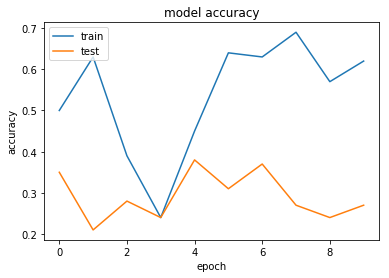

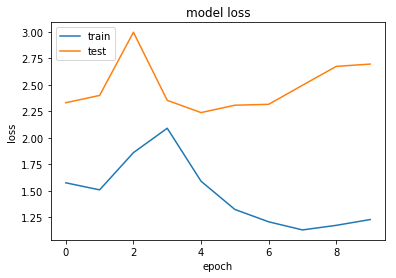

In [22]:
import matplotlib.pyplot as plt
plt.plot(historyCNNPlus.history['acc'])
plt.plot(historyCNNPlus.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(historyCNNPlus.history['loss'])
plt.plot(historyCNNPlus.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Evaluate Models